# BIKE SHARING DEMAND PREDICTION
*Forecast use of a city bikeshare system*
###### Collaborators: [Erike Nasyah Herman](https://www.linkedin.com/in/erikenasyahherman/), [Kevin](https://www.linkedin.com/in/kevinchenkc/), [Reyhan Alif Pradityo](https://www.linkedin.com/in/alifreyhanp/)
![santander](santander.avif)

<hr>

## Project Overview
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world (2015).

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this project, we combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

## Data Overview
- Source: [Kaggle](https://www.kaggle.com/competitions/bike-sharing-demand/overview)
- Provider: **Hadi Fanaee Tork** using data from **Capital Bikeshare**
- Relevant papers: Fanaee-T, Hadi, and Gama, Joao, *Event labeling combining ensemble detectors and background knowledge*, Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.

## Problem Statement
Bike sharing provider in US recently suffered revenue decrease due to Covid Pandemic and Lockdown Situation. They are planning to prepare a business plan so once the lockdown has ended, they could recover quickly. To be able to create a mindful business plan, bike sharing provider needs to understand the demand of bike sharing. By understanding the bike sharing demand, they could choose the right strategies like

    1. Whether they should buy new bikes to accomodate the demand and meet customer's expectation
    2. How to manage bikes amount in station to maintain bike condition and avoid larceny

## Goals
`We have to create a model to predict the demand for shared bikes with given varables like time, weather, temperature, humidity, and windspeed`

<hr>

## Project Preparation
Before we perform data understanding, data wrangling and further Exploratory Data Analysis (EDA) to obtain preliminary insights of the data set, we import packages to be used and import the data set to DataFrame as well.

In [174]:
## Import packages
import sklearn #scikit-learn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [175]:
## Import Data Set 'train'
url = 'https://raw.githubusercontent.com/kevinchenkc/Bike-Sharing-Demand-Prediction/main/train.csv'
df_train = pd.read_csv(url)
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<hr>

## Data Understanding and Data Wrangling

In [176]:
## Define shapes of each dataframe
print(f'Shape of training set: {df_train.shape}')

Shape of training set: (10886, 12)


In [177]:
## Define columns of each dataframe
print(f'Columns of training set: {df_train.columns}')

Columns of training set: Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


### Data Fields Description
source: [kaggle.com](https://www.kaggle.com/competitions/bike-sharing-demand/data)
- `datetime` - hourly date + timestamp  
- `season`
    1. spring
    2. summer
    3. fall
    4. winter 
- `holiday` - whether the day is considered a holiday
- `workingday` - whether the day is neither a weekend nor holiday
- `weather` 
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp` - temperature in Celsius
- `atemp` - "feels like" temperature in Celsius
- `humidity` - relative humidity
- `windspeed` - wind speed
- `casual` - number of non-registered user rentals initiated
- `registered` - number of registered user rentals initiated
- `count` - number of total rentals

### Feature Extraction - Datetime

In [178]:
## Data Type Conversion for Training Set and Test Set
df_train['datetime']=pd.to_datetime(df_train['datetime'])

In [179]:
## Extract year, month, day, hour column from datetime column in train dataset
df_train.insert(1, 'hour', df_train['datetime'].dt.hour)
df_train.insert(1, 'day', df_train['datetime'].dt.day)
df_train.insert(1, 'month', df_train['datetime'].dt.month)
df_train.insert(1, 'year', df_train['datetime'].dt.year)

df_train.head()

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Check and Handle Outliers

In [180]:
## Data Description of Training Set
dataDesc=[]
for i in df_train.columns:
    dataDesc.append([
        i,
        df_train[i].dtypes,
        df_train[i].isna().sum(),
        round((((df_train[i].isna().sum())/len(df_train))*100),2),
        df_train[i].nunique(),
        df_train[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(dataDesc, columns=[
    'Data Features',
    'Data Types',
    'Null',
    'Null Percentage',
    'Unique',
    'Unique Sample'
])
## Result: no null/missing value, there're 12 columns with 11 of them are numeric and datetime column is object.

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,datetime,datetime64[ns],0,0.0,10886,"[2012-06-10T14:00:00.000000000, 2011-03-15T15:..."
1,year,int64,0,0.0,2,"[2012, 2011]"
2,month,int64,0,0.0,12,"[8, 10]"
3,day,int64,0,0.0,19,"[13, 8]"
4,hour,int64,0,0.0,24,"[7, 23]"
5,season,int64,0,0.0,4,"[3, 2]"
6,holiday,int64,0,0.0,2,"[0, 1]"
7,workingday,int64,0,0.0,2,"[0, 1]"
8,weather,int64,0,0.0,4,"[1, 4]"
9,temp,float64,0,0.0,49,"[14.76, 15.58]"


In [181]:
## Data Type Conversion for Training Set
df_train['datetime']=pd.to_datetime(df_train['datetime'])

## Confirm Conversion Result
df_train.dtypes
## Result: datetime column has been converted into datetime type

datetime      datetime64[ns]
year                   int64
month                  int64
day                    int64
hour                   int64
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [182]:
## Describe numerical columns to detect outliers
df_train.describe()
## Result: we excluded categorical-encoded columns for outlier test since they are not continuous number. 
### Categorical-encoded columns consist of season, holiday, workingday and weather.
### We also did not perform outlier testing to casual and registered columns since it only shows proportion of registered and unregistered rentor in a transaction.

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011.501929,6.521495,9.992559,11.541613,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,0.500019,3.444373,5.476608,6.915838,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,2011.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011.000000,4.000000,5.000000,6.000000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012.000000,7.000000,10.000000,12.000000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012.000000,10.000000,15.000000,18.000000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012.000000,12.000000,19.000000,23.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


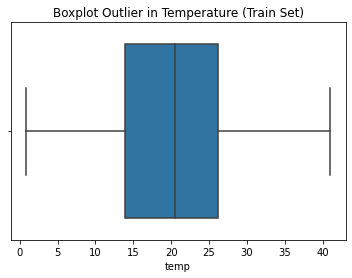

In [183]:
## Check outliers in 'temp'
sns.boxplot(df_train['temp'])
plt.title('Boxplot Outlier in Temperature (Train Set)')
plt.show()
## Result: No outliers

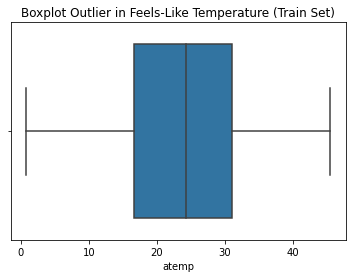

In [184]:
## Check outliers in 'atemp'
sns.boxplot(df_train['atemp'])
plt.title('Boxplot Outlier in Feels-Like Temperature (Train Set)')
plt.show()
## Result: No outliers

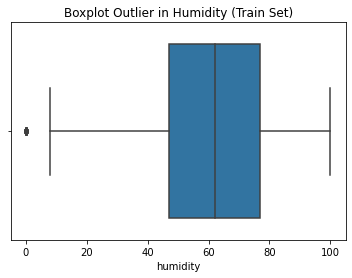

In [185]:
## Check outliers in 'humidity'
sns.boxplot(df_train['humidity'])
plt.title('Boxplot Outlier in Humidity (Train Set)')
plt.show()
## Result: There are outliers with 0 humidity

In [186]:
## Create outliers checking function
def check_outliers(df_train,col):
    Q1=df_train[col].describe()['25%']
    Q3=df_train[col].describe()['75%']
    IQR=Q3-Q1
    Upper_fence=Q3+(1.5*IQR)
    Lower_fence=Q1-(1.5*IQR)
    df_outliers=df_train[(df_train[col]<Lower_fence) | (df_train[col]>Upper_fence)]
    if len(df_outliers)==0:
        return 'No Outliers'
    else:
        return df_outliers

In [187]:
## Show outliers in humidity
outliers_humidity=check_outliers(df_train,'humidity')
outliers_humidity

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1091,2011-03-10 00:00:00,2011,3,10,0,1,0,1,3,13.94,15.910,0,16.9979,3,0,3
1092,2011-03-10 01:00:00,2011,3,10,1,1,0,1,3,13.94,15.910,0,16.9979,0,2,2
1093,2011-03-10 02:00:00,2011,3,10,2,1,0,1,3,13.94,15.910,0,16.9979,0,1,1
1094,2011-03-10 05:00:00,2011,3,10,5,1,0,1,3,14.76,17.425,0,12.9980,1,2,3
1095,2011-03-10 06:00:00,2011,3,10,6,1,0,1,3,14.76,16.665,0,22.0028,0,12,12
1096,2011-03-10 07:00:00,2011,3,10,7,1,0,1,3,15.58,19.695,0,15.0013,1,36,37
1097,2011-03-10 08:00:00,2011,3,10,8,1,0,1,3,15.58,19.695,0,19.0012,1,43,44
1098,2011-03-10 09:00:00,2011,3,10,9,1,0,1,3,16.40,20.455,0,15.0013,1,23,24
1099,2011-03-10 10:00:00,2011,3,10,10,1,0,1,3,16.40,20.455,0,11.0014,0,17,17
1100,2011-03-10 11:00:00,2011,3,10,11,1,0,1,3,16.40,20.455,0,16.9979,6,5,11


In [188]:
## Define shape of outliers in humidity
print(f'Number of outliers data in humidity: {outliers_humidity.shape[0]}')
print(f'Total rows of data: {df_train.shape[0]}')
print(f'Percentage of outliers to total data (%): {(outliers_humidity.shape[0]/df_train.shape[0])*100}')
## Result: since proportion of outliers in humidity towards total data is only 0.2%, we drop this outliers from the data set.

Number of outliers data in humidity: 22
Total rows of data: 10886
Percentage of outliers to total data (%): 0.20209443321697593


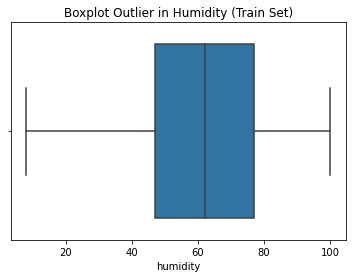

In [189]:
## Drop outliers data of humidity columns
df_train.drop(outliers_humidity.index,inplace=True)

## Re-Check outliers in 'humidity'
sns.boxplot(df_train['humidity'])
plt.title('Boxplot Outlier in Humidity (Train Set)')
plt.show()
## Result: No outliers

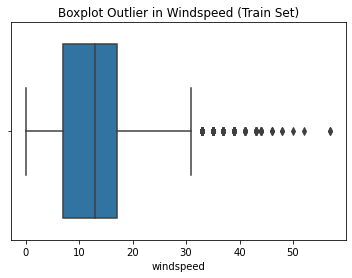

In [190]:
## Check outliers in 'windspeed'
sns.boxplot(df_train['windspeed'])
plt.title('Boxplot Outlier in Windspeed (Train Set)')
plt.show()
## Result: There are outliers above 30 windspeed

In [191]:
## Show outliers in windspeed
outliers_windspeed=check_outliers(df_train,'windspeed')
outliers_windspeed

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
175,2011-01-08 14:00:00,2011,1,8,14,1,0,0,1,8.20,8.335,32,32.9975,12,83,95
178,2011-01-08 17:00:00,2011,1,8,17,1,0,0,1,6.56,6.060,37,36.9974,5,64,69
194,2011-01-09 09:00:00,2011,1,9,9,1,0,0,1,4.92,3.790,46,35.0008,0,19,19
196,2011-01-09 11:00:00,2011,1,9,11,1,0,0,1,6.56,6.060,40,35.0008,2,47,49
265,2011-01-12 12:00:00,2011,1,12,12,1,0,1,1,8.20,7.575,47,39.0007,3,52,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,2012-11-02 14:00:00,2012,11,2,14,4,0,1,2,16.40,20.455,40,32.9975,63,199,262
10154,2012-11-08 12:00:00,2012,11,8,12,4,0,1,1,16.40,20.455,24,32.9975,33,202,235
10263,2012-11-13 01:00:00,2012,11,13,1,4,0,1,3,18.04,21.970,88,43.0006,0,5,5
10540,2012-12-05 14:00:00,2012,12,5,14,4,0,1,1,19.68,23.485,33,32.9975,39,179,218


In [192]:
## Define shape of outliers in windspeed
print(f'Number of outliers data in windspeed: {outliers_windspeed.shape[0]}')
print(f'Total rows of data: {df_train.shape[0]}')
print(f'Percentage of outliers to total data (%): {(outliers_windspeed.shape[0]/df_train.shape[0])*100}')
## Result: since proportion of outliers in windspeed towards total data is only 2.08%, we drop this outliers from the data set.

Number of outliers data in windspeed: 226
Total rows of data: 10864
Percentage of outliers to total data (%): 2.080265095729013


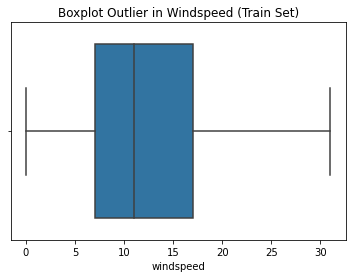

In [193]:
## Drop outliers data of windspeed columns
df_train.drop(outliers_windspeed.index,inplace=True)

## Re-Check outliers in 'windspeed'
sns.boxplot(df_train['windspeed'])
plt.title('Boxplot Outlier in Windspeed (Train Set)')
plt.show()
## Result: No outliers

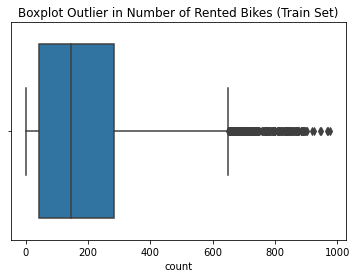

In [194]:
## Check outliers in 'count'
sns.boxplot(df_train['count'])
plt.title('Boxplot Outlier in Number of Rented Bikes (Train Set)')
plt.show()
## Result: There are outliers with more than 600 bikes rented on one occassion.

In [195]:
## Show outliers in count
outliers_bikes=check_outliers(df_train,'count')
outliers_bikes

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
6611,2012-03-12 18:00:00,2012,3,12,18,1,0,1,2,24.60,31.060,43,12.9980,89,623,712
6634,2012-03-13 17:00:00,2012,3,13,17,1,0,1,1,28.70,31.820,37,7.0015,62,614,676
6635,2012-03-13 18:00:00,2012,3,13,18,1,0,1,1,28.70,31.820,34,19.9995,96,638,734
6649,2012-03-14 08:00:00,2012,3,14,8,1,0,1,1,18.04,21.970,82,0.0000,34,628,662
6658,2012-03-14 17:00:00,2012,3,14,17,1,0,1,1,28.70,31.820,28,6.0032,140,642,782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,2012-12-11 08:00:00,2012,12,11,8,4,0,1,2,13.94,15.150,61,19.9995,16,708,724
10702,2012-12-12 08:00:00,2012,12,12,8,4,0,1,2,10.66,12.880,65,11.0014,18,670,688
10726,2012-12-13 08:00:00,2012,12,13,8,4,0,1,1,9.84,11.365,60,12.9980,24,655,679
10846,2012-12-18 08:00:00,2012,12,18,8,4,0,1,1,15.58,19.695,94,0.0000,10,652,662


In [196]:
## Define shape of outliers in bikes
print(f'Number of outliers data in bikes: {outliers_bikes.shape[0]}')
print(f'Total rows of data: {df_train.shape[0]}')
print(f'Percentage of outliers to total data (%): {(outliers_bikes.shape[0]/df_train.shape[0])*100}')
## Result: since proportion of outliers in rented bikes towards total data is only 2.69%, we drop this outliers from the data set.

Number of outliers data in bikes: 286
Total rows of data: 10638
Percentage of outliers to total data (%): 2.6884752773077647


In [197]:
## Drop outliers data of bikes columns
df_train.drop(outliers_bikes.index,inplace=True)

In [198]:
## Reset Index after dropping outliers data
df_train.reset_index(inplace=True)

## Drop original column index
df_train.drop(columns='index',inplace=True)

## Show Updated DataFrame
df_train

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10347,2012-12-19 19:00:00,2012,12,19,19,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10348,2012-12-19 20:00:00,2012,12,19,20,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10349,2012-12-19 21:00:00,2012,12,19,21,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10350,2012-12-19 22:00:00,2012,12,19,22,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


---

### Quick Exploratory Data Analysis (EDA)

1. Bagaimana tren peminjaman sepeda tiap bulan dalam satu tahun?
2. Bagaimana tren peminjaman sepeda tiap musim dalam satu tahun?
3. Bagaimana temperatur mempengaruhi jumlah peminjaman sepeda?
4. Bagaimana  temperatur 'feels like' mempengaruhi jumlah peminjaman sepeda?
5. Bagaimana tingkat kelembaban udara mempengaruhi jumlah peminjaman sepeda?
6. Bagaimana kecepatan angin mempengaruhi peminjaman jumlah sepeda?

<Figure size 1440x1440 with 0 Axes>

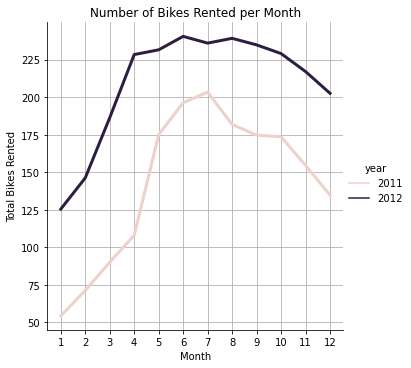

In [199]:
## 1. Bikes Rental Trend per Month 
plt.figure(figsize=(20, 20))
sns.relplot(x="month", y="count", hue="year",kind="line", linewidth=3, ci=None,data=df_train)
plt.xticks(np.arange(1,13))
plt.xlabel('Month')
plt.ylabel('Total Bikes Rented')
plt.title('Number of Bikes Rented per Month',size=12)
plt.grid(True)
plt.show()

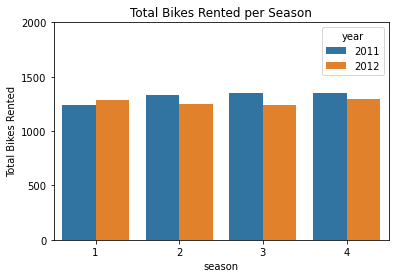

In [200]:
## 2. Bagaimana tren peminjaman sepeda tiap musim dalam satu tahun?
sns.countplot(x='season',data=df_train,hue='year')
plt.yticks(np.arange(0,2001,500))
plt.ylabel('Total Bikes Rented')
plt.title('Total Bikes Rented per Season',size=12)
plt.show()

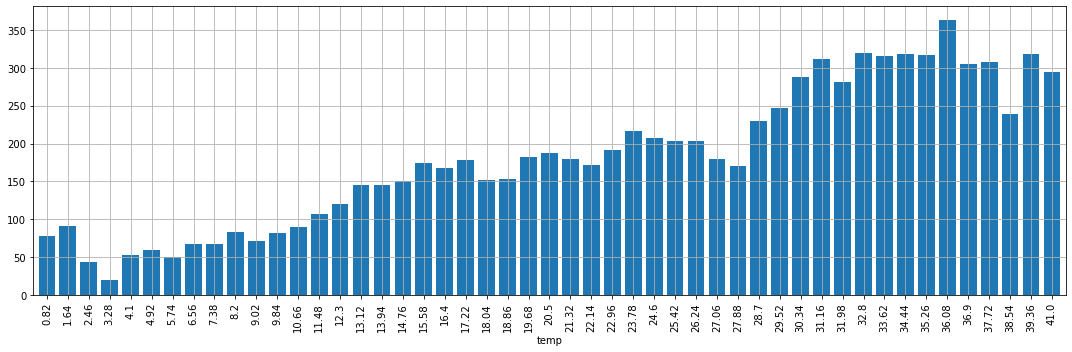

<Figure size 720x720 with 0 Axes>

In [201]:
## 3 Bagaimana temperatur mempengaruhi jumlah peminjaman sepeda?
suhu = df_train.groupby(['temp'])['count'].agg('mean')
suhu.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout();
plt.figure(figsize=(10, 10))
plt.show()

Terlihat bahwa temperatur yang semakin meningkat menjadikan semakin banyak pengguna layanan peminjaman sepeda. Terlihat dari grafik terdapat tren kenaikan peminjaman sepeda dari suhu 4 hingga 29 derajat Celcius. Terjadi penurunan jumlah peminjam jika suhu semakin meninggi dari suhu 30 hingga 40 derajat Celcius

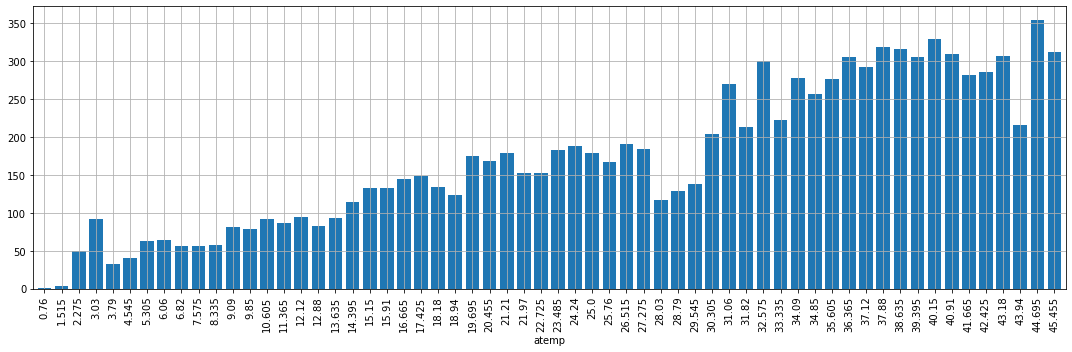

<Figure size 720x720 with 0 Axes>

In [202]:
## 4. Bagaimana  temperatur 'feels like' mempengaruhi jumlah peminjaman sepeda?
suhu_f = df_train.groupby(['atemp'])['count'].agg('mean')
suhu_f.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout();
plt.figure(figsize=(10, 10))
plt.show()

Grafik ini menunjukkan pengaruh suhu yang dirasakan manusia dengan jumlah peminjaman sepeda. Grafik menunjukkan tren peningkatan 
peminjaman sepeda seiring meningkatnya suhu, hingga di suhu 31 derajat merupakan suhu yang paling banyak peminjaman sepeda.

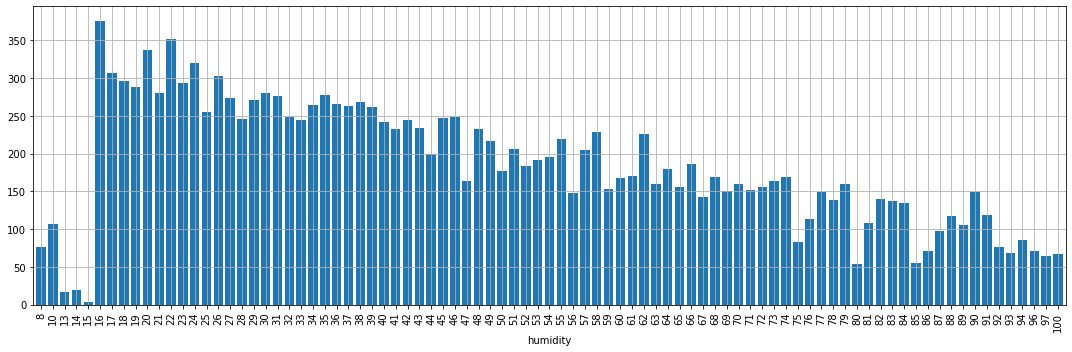

<Figure size 720x720 with 0 Axes>

In [203]:
# 5. Bagaimana tingkat kelembaban udara mempengaruhi jumlah peminjaman sepeda?
suhu = df_train.groupby(['humidity'])['count'].agg('mean')
suhu.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout();
plt.figure(figsize=(10, 10))
# sns.displot(df_train, x="temp", kde=True)
plt.show()

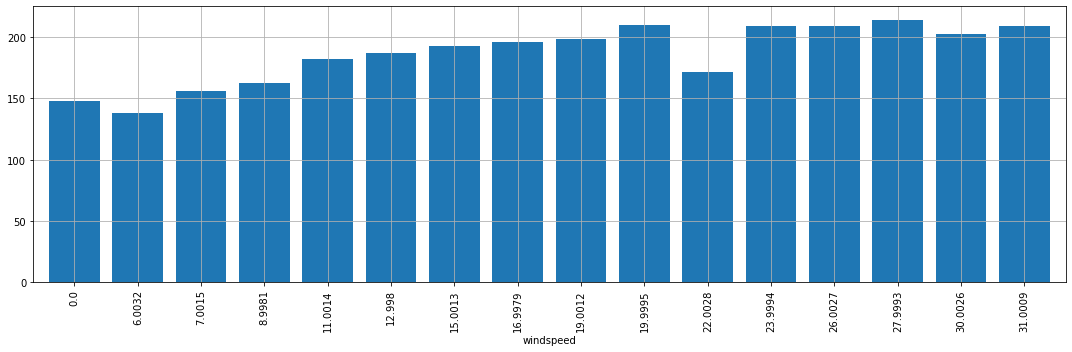

<Figure size 720x720 with 0 Axes>

In [204]:
# 6. Bagaimana kecepatan angin mempengaruhi peminjaman jumlah sepeda?
suhu = df_train.groupby(['windspeed'])['count'].agg('mean')
suhu.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout();
plt.figure(figsize=(10, 10))
plt.show()

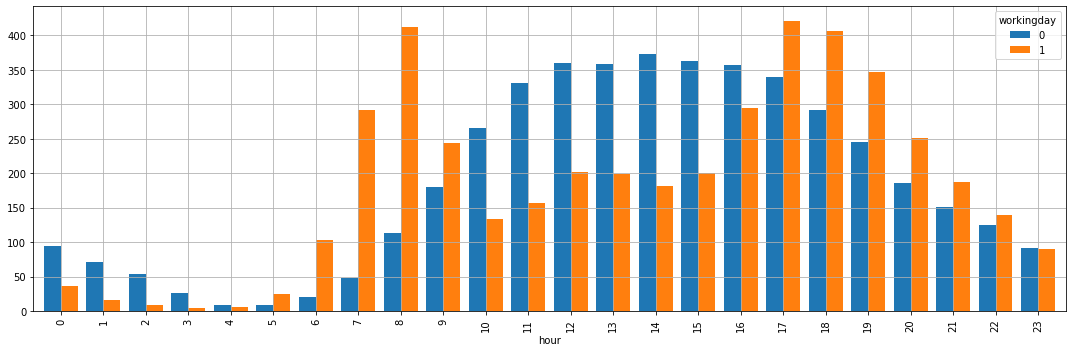

In [205]:
by_hour = df_train.groupby(['hour', 'workingday'])['count'].agg('mean').unstack()
by_hour.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout();

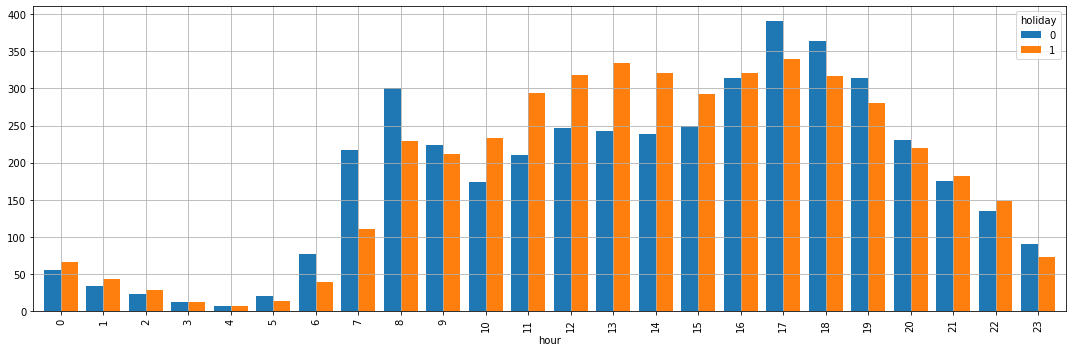

In [206]:
# Grafik menunjukkan di hari kerja terdapat tren peningkatan peminjaman sepeda di jam-jam tertentu dari jam 6-9 pagi dan jam 15-17 sore.
by_hour = df_train.groupby(['hour', 'holiday'])['count'].agg('mean').unstack()
by_hour.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout();

Grafik di atas menunjukkan data kecepatan angin dengan jumlah peminjaman sepeda. Di hari yang kecepatan angin dengan klasifikasi Calm Air dan Gentle Breeze (0-20 km/jam) menjadi hari yang favorit untuk bersepeda, sedangkan Moderate Wind menunjukkan tren penurunan peminjaman sepeda

<hr>

## Feature Selection

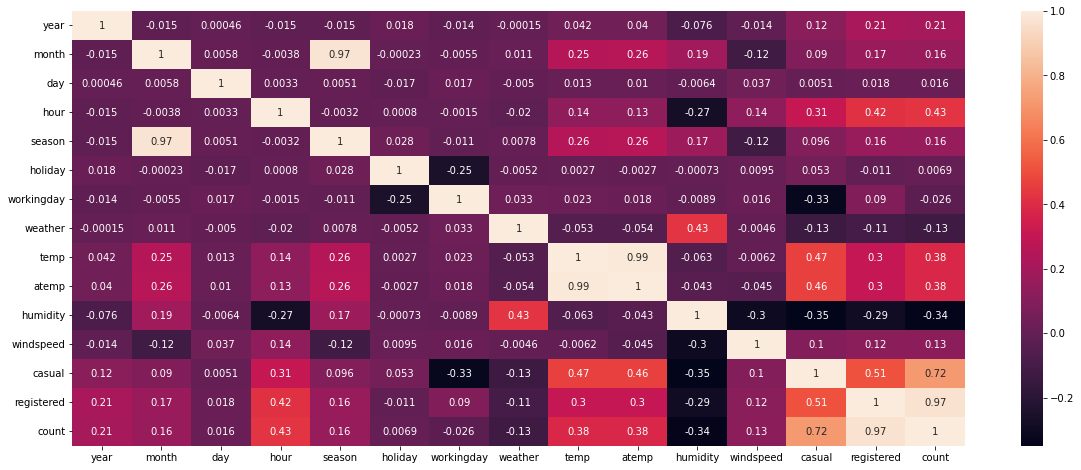

In [207]:
## Correlation Test with HeatMap
plt.figure(figsize=(20,8))
sns.heatmap(df_train.corr(),annot=True)
plt.show()
## We use Pearson for correlation test since we have took out the outliers.
### We only analyze correlation all columns with 'count'.
#### Result: We use all columns as features since the correlation score are not consistenly formed between columns.

<hr>

## Machine Learning

### Splitting Data

In [208]:
## Import package
from sklearn.model_selection import train_test_split

In [209]:
# Define features and target
x=df_train.drop(columns=['count','datetime','season','casual','registered'])
y=df_train['count']

In [210]:
## Split Data with proportion of 85% train : 15% test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15)

### Machine Learning Modelling

In [211]:
## Import package
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [212]:
## Assign models to variable
Model_LR=LinearRegression(fit_intercept=False) # when all features have value of 0, it didn't automatically translated into no bikes rented
Model_P=PolynomialFeatures(degree=3,include_bias=True,interaction_only=False)
Model_P_LR=LinearRegression(fit_intercept=False) # when all features have value of 0, it didn't automatically translated into no bikes rented
Model_R=Ridge()
Model_L=Lasso()
Model_E=ElasticNet()

In [213]:
# Learning Model -> finding pattern from question-answer of Training Data
Model_LR.fit(x_train,y_train)
Model_P.fit(x_train,y_train)
Model_R.fit(x_train,y_train)
Model_L.fit(x_train,y_train)
Model_E.fit(x_train,y_train)

ElasticNet()

In [214]:
## Assign transformed training and testing set into variables for Polynomial Model
x_train_poly=Model_P.transform(x_train)
x_test_poly=Model_P.transform(x_test)

In [215]:
## Learning Model for Linear Regression after Polynomial Features
Model_P_LR.fit(x_train_poly,y_train)

LinearRegression(fit_intercept=False)

In [216]:
## Predicted Target
pred_test_LR=Model_LR.predict(x_test)
pred_test_P_LR_train=Model_P_LR.predict(x_train_poly)
pred_test_P_LR_test=Model_P_LR.predict(x_test_poly)
pred_test_R=Model_R.predict(x_test)
pred_test_L=Model_L.predict(x_test)
pred_test_E=Model_E.predict(x_test)

#### Training Model

In [217]:
## Describe shape of train features
x_train.shape

(8799, 11)

In [218]:
## Show train features
x_train.head()

,year,month,day,hour,holiday,workingday,weather,temp,atemp,humidity,windspeed
9386,2012,10,15,23,0,1,1,18.86,22.725,63,15.0013
6194,2012,3,2,21,0,1,3,14.76,18.180,87,6.0032
1264,2011,4,1,21,0,1,1,13.12,16.665,53,8.9981
5606,2012,1,15,6,0,0,2,5.74,6.060,50,19.0012
2829,2011,7,11,18,0,1,1,35.26,41.665,53,26.0027


In [219]:
## Convert train features to DataFrame
df_x_train=pd.DataFrame(x_train)
df_x_train.head()

,year,month,day,hour,holiday,workingday,weather,temp,atemp,humidity,windspeed
9386,2012,10,15,23,0,1,1,18.86,22.725,63,15.0013
6194,2012,3,2,21,0,1,3,14.76,18.180,87,6.0032
1264,2011,4,1,21,0,1,1,13.12,16.665,53,8.9981
5606,2012,1,15,6,0,0,2,5.74,6.060,50,19.0012
2829,2011,7,11,18,0,1,1,35.26,41.665,53,26.0027


#### Testing Model

In [220]:
## Describe shape of test features
x_test.shape

(1553, 11)

In [221]:
## Show test features
x_test.head()

,year,month,day,hour,holiday,workingday,weather,temp,atemp,humidity,windspeed
3087,2011,8,3,14,0,1,2,31.16,35.605,58,15.0013
2253,2011,6,6,15,0,1,1,32.80,34.850,29,12.9980
2160,2011,6,2,18,0,1,1,30.34,32.575,22,26.0027
4909,2011,12,4,9,0,0,1,12.30,16.665,81,0.0000
5028,2011,12,9,11,0,1,1,13.12,15.150,70,16.9979


In [222]:
## Convert test features to DataFrame
df_x_test=pd.DataFrame(x_test)
df_x_train_poly=pd.DataFrame(x_train_poly)
df_x_test_poly=pd.DataFrame(x_test_poly)

<hr>

## Evaluation Matrix

### Check and Compare Evaluation Matrix

In [223]:
## Create function for evaluation matrix
def Eva_Matrix(Model,x,y_true):
    y_pred=Model.predict(x)
    R2=r2_score(y_true,y_pred)
    MAE=mean_absolute_error(y_true,y_pred)
    MSE=mean_squared_error(y_true,y_pred)
    RMSE=np.sqrt(MSE)
    return R2,MAE,MSE,RMSE

In [224]:
## Linear Regression Training
r2_LR_Train,MAE_LR_Train,MSE_LR_Train,RMSE_LR_Train=Eva_Matrix(Model_LR,df_x_train,y_train)
## Linear Regression Testing
r2_LR_Test,MAE_LR_Test,MSE_LR_Test,RMSE_LR_Test=Eva_Matrix(Model_LR,df_x_test,y_test)
## Linear Regression with Polynomial Features Training
r2_P_LR_Train,MAE_P_LR_Train,MSE_P_LR_Train,RMSE_P_LR_Train=Eva_Matrix(Model_P_LR,df_x_train_poly,y_train)
## Linear Regression with Polynomial Features Training
r2_P_LR_Test,MAE_P_LR_Test,MSE_P_LR_Test,RMSE_P_LR_Test=Eva_Matrix(Model_P_LR,df_x_test_poly,y_test)
## Ridge Training
r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train=Eva_Matrix(Model_R,df_x_train,y_train)
## Ridge Testing
r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test=Eva_Matrix(Model_R,df_x_test,y_test)
## Lasso Training
r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train=Eva_Matrix(Model_L,df_x_train,y_train)
## Lasso Testing
r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test=Eva_Matrix(Model_L,df_x_test,y_test)
## ElasticNet Training
r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train=Eva_Matrix(Model_E,df_x_train,y_train)
## ElasticNet Testing
r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train=Eva_Matrix(Model_E,df_x_test,y_test)

In [225]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Linear Regression Training':[r2_LR_Train,MAE_LR_Train,MSE_LR_Train,RMSE_LR_Train],
    'Linear Regression Testing':[r2_LR_Test,MAE_LR_Test,MSE_LR_Test,RMSE_LR_Test],
    'LinReg after Polynomial Features Training':[r2_P_LR_Train,MAE_P_LR_Train,MSE_P_LR_Train,RMSE_P_LR_Train],
    'LinReg after Polynomial Features Testing':[r2_P_LR_Test,MAE_P_LR_Test,MSE_P_LR_Test,RMSE_P_LR_Test],
    'Ridge Training':[r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train],
    'Ridge Testing':[r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test],
    'Lasso Training':[r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train],
    'Lasso Testing':[r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test],
    'Elasticnet Training':[r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train],
    'Elasticnet Testing':[r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train],    
}
summary1=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary1.T

,R-Squared,MAE,MSE,RMSE
Linear Regression Training,0.36,95.41,15713.53,125.35
Linear Regression Testing,0.37,94.46,15507.58,124.53
LinReg after Polynomial Features Training,0.67,65.60,8158.41,90.32
LinReg after Polynomial Features Testing,0.63,69.20,9017.06,94.96
Ridge Training,0.40,92.95,14858.32,121.89
Ridge Testing,0.39,93.29,14961.48,122.32
Lasso Training,0.40,93.03,14868.56,121.94
Lasso Testing,0.39,93.24,14940.30,122.23
Elasticnet Training,0.39,93.58,15159.33,123.12
Elasticnet Testing,0.39,93.58,15159.33,123.12


---

## ML Improvement 1 - Regularization 

### Manual Tuning

In [234]:
## Preliminary Alpha List to be Tested
parameter_a=[0.001,0.01,1,10,20,30,40,50,100]

In [235]:
## Use only R-Squared to Compare
train_rsq_R=[]
test_rsq_R=[]
train_rsq_L=[]
test_rsq_L=[]
train_rsq_E=[]
test_rsq_E=[]

for i in parameter_a:
    ## Ridge Training
    model_R=Ridge(alpha=i)
    model_R.fit(df_x_train_poly,y_train)
    y_predR_train=model_R.predict(df_x_train_poly)
    R2_ridge_train=r2_score(y_train,y_predR_train)
    train_rsq_R.append(R2_ridge_train)

    ## Ridge Testing
    y_predR_test=model_R.predict(df_x_test_poly)
    R2_ridge_test=r2_score(y_test,y_predR_test)
    test_rsq_R.append(R2_ridge_test)

    ## Lasso Training
    model_L=Lasso(alpha=i)
    model_L.fit(df_x_train_poly,y_train)
    y_predL_train=model_L.predict(df_x_train_poly)
    R2_lasso_train=r2_score(y_train,y_predL_train)
    train_rsq_L.append(R2_lasso_train)

    ## Lasso Testing
    y_predL_test=model_L.predict(df_x_test_poly)
    R2_lasso_test=r2_score(y_test,y_predL_test)
    test_rsq_L.append(R2_lasso_test)

    ## ElasticNet Training
    model_E=ElasticNet(alpha=i,l1_ratio=0.6)
    model_E.fit(df_x_train_poly,y_train)
    y_predE_train=model_E.predict(df_x_train_poly)
    R2_elasticnet_train=r2_score(y_train,y_predE_train)
    train_rsq_E.append(R2_elasticnet_train)

    ## ElasticNet Testing
    y_predE_test=model_E.predict(df_x_test_poly)
    R2_elasticnet_test=r2_score(y_test,y_predE_test)
    test_rsq_E.append(R2_elasticnet_test)

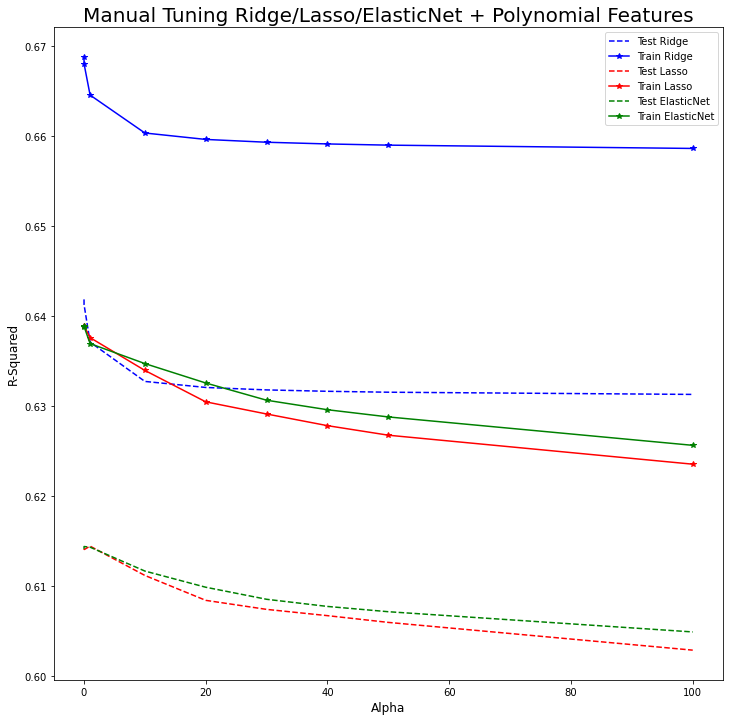

In [236]:
## Visualization
plt.figure(figsize=(12,12))
plt.plot(parameter_a,test_rsq_R,'b--',linewidth=1.5)
plt.plot(parameter_a,train_rsq_R,'b*-',linewidth=1.5)
plt.plot(parameter_a,test_rsq_L,'r--',linewidth=1.5)
plt.plot(parameter_a,train_rsq_L,'r*-',linewidth=1.5)
plt.plot(parameter_a,test_rsq_E,'g--',linewidth=1.5)
plt.plot(parameter_a,train_rsq_E,'g*-',linewidth=1.5)
plt.legend(['Test Ridge','Train Ridge','Test Lasso','Train Lasso','Test ElasticNet','Train ElasticNet'])
plt.title('Manual Tuning Ridge/Lasso/ElasticNet + Polynomial Features',size=20)
plt.ylabel('R-Squared',size=12)
plt.xlabel('Alpha',size=12)
plt.show()

In [237]:
## search Alpha for highest R-Squared result per category
print(f'Ridge with Polynomial after Manual Tuning Train = {parameter_a[np.argmax(train_rsq_R)]}')
print(f'Ridge with Polynomial after Manual Tuning Test = {parameter_a[np.argmax(test_rsq_R)]}')
print(f'Lasso with Polynomial after Manual Tuning Train = {parameter_a[np.argmax(train_rsq_L)]}')
print(f'Lasso with Polynomial after Manual Tuning Test = {parameter_a[np.argmax(test_rsq_L)]}')
print(f'ElasticNet with Polynomial after Manual Tuning (L1_Ratio 0.6) Train = {parameter_a[np.argmax(train_rsq_E)]}')
print(f'ElasticNet with Polynomial after Manual Tuning (L1_Ratio 0.6) Test = {parameter_a[np.argmax(test_rsq_E)]}')

Ridge with Polynomial after Manual Tuning Train = 0.001
Ridge with Polynomial after Manual Tuning Test = 0.001
Lasso with Polynomial after Manual Tuning Train = 0.001
Lasso with Polynomial after Manual Tuning Test = 1
ElasticNet with Polynomial after Manual Tuning (L1_Ratio 0.6) Train = 0.001
ElasticNet with Polynomial after Manual Tuning (L1_Ratio 0.6) Test = 0.01


In [238]:
model_R=Ridge(alpha=parameter_a[np.argmax(test_rsq_R)]) # Define Model dengan nilai Alpha sesuai nilai alpha maximum
model_R.fit(df_x_train_poly,y_train) # Training Model
model_L=Ridge(alpha=parameter_a[np.argmax(test_rsq_L)]) # Define Model dengan nilai Alpha sesuai nilai alpha maximum
model_L.fit(df_x_train_poly,y_train) # Training Model
model_E=Ridge(alpha=parameter_a[np.argmax(test_rsq_E)]) # Define Model dengan nilai Alpha sesuai nilai alpha maximum
model_E.fit(df_x_train_poly,y_train) # Training Model

Ridge(alpha=0.01)

In [240]:
## Ridge Training
r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train=Eva_Matrix(model_R,df_x_train_poly,y_train)
## Ridge Testing
r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test=Eva_Matrix(model_R,df_x_test_poly,y_test)
## Lasso Training
r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train=Eva_Matrix(model_L,df_x_train_poly,y_train)
## Lasso Testing
r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test=Eva_Matrix(model_L,df_x_test_poly,y_test)
## ElasticNet Training
r2_ElasticNet_Train,MAE_ElasticNet_Train,MSE_ElasticNet_Train,RMSE_ElasticNet_Train=Eva_Matrix(model_E,df_x_train_poly,y_train)
## ElasticNet Testing
r2_ElasticNet_Test,MAE_ElasticNet_Test,MSE_ElasticNet_Test,RMSE_ElasticNet_Test=Eva_Matrix(model_E,df_x_test_poly,y_test)

In [242]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Ridge(a=0.001)+Poly Training':[r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train],
    'Ridge(a=0.001)+Poly Testing':[r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test],
    'Lasso(a=1)+Poly Training':[r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train],
    'Lasso(a=1)+Poly Testing':[r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test],
    'ElasticNet(a=0.01)+Poly Training':[r2_ElasticNet_Train,MAE_ElasticNet_Train,MSE_ElasticNet_Train,RMSE_ElasticNet_Train],
    'ElasticNet(a=0.01)+Poly Testing':[r2_ElasticNet_Test,MAE_ElasticNet_Test,MSE_ElasticNet_Test,RMSE_ElasticNet_Test],
}
summary1_1=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary1_1.T

,R-Squared,MAE,MSE,RMSE
Ridge(a=0.001)+Poly Training,0.67,65.52,8157.12,90.32
Ridge(a=0.001)+Poly Testing,0.64,68.62,8831.71,93.98
Lasso(a=1)+Poly Training,0.66,65.89,8260.94,90.89
Lasso(a=1)+Poly Testing,0.64,68.99,8948.81,94.60
ElasticNet(a=0.01)+Poly Training,0.67,65.58,8175.57,90.42
ElasticNet(a=0.01)+Poly Testing,0.64,68.68,8846.34,94.05


---

## ML Improvement 2 - Binning

Dari quick EDA mengenai persebaran jumlah peminjam berdasarkan jam, dapat diketahui peminjam paling banyak berada pada jam 17 dengan rata-rata jumlah peminjam 389. Sedangkan yang terendah terdapat pada jam 4 dengan rata-rata 4 peminjam. Berdasarkan EDA tersebut, kita dapat melakukan binning berdasarkan tingkat peminjaman ('High', 'Medium','Low') atau langsung berdasarkan urutan (2, 1, dan 0)

In [243]:
df_train['hour_bin']=pd.cut(df_train['hour'], bins=3, labels=np.arange(0,3)).astype('int64')

Dari quick EDA mengenai persebaran jumlah peminjam berdasarkan temperatur, dapat diketahui peminjam paling banyak berada pada temperatur 36.8 dengan rata-rata jumlah peminjam 350. Sedangkan yang terendah terdapat pada temp 3 dereajat dengan rata-rata 25 peminjam. Berdasarkan EDA tersebut, kita dapat melakukan binning berdasarkan tingkat suhu ('High', 'Medium','Low') atau langsung berdasarkan urutan (2, 1, dan 0)

In [244]:
df_train['temp_bin']=pd.cut(df_train['temp'], bins=3, labels=np.arange(0,3)).astype('int64')

terdapat 4 feature yang menunjukkan cuaca dalam dataset. feature cuaca dapat kita kelompokkan lagi menjadi kondisi hujan dan tidak hujan
    hujan = 1
    tidak hujan = 0

In [245]:
df_train['weather_bin']=df_train['weather'].apply(lambda x: 1 if x>2 else 0)

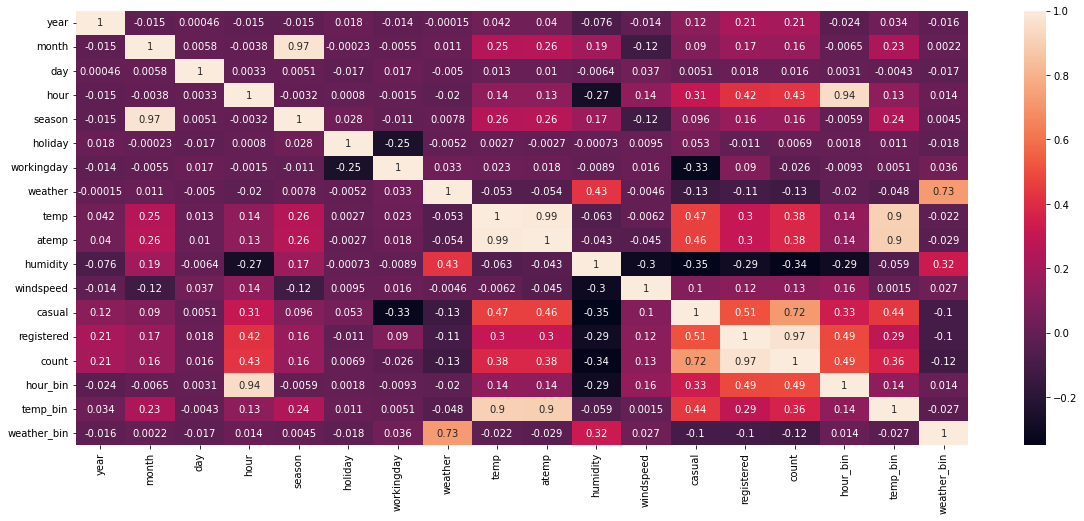

In [246]:
## Correlation Test with HeatMap
plt.figure(figsize=(20,8))
sns.heatmap(df_train.corr(),annot=True)
plt.show()
## We use Pearson for correlation test since we have took out the outliers.
### We only analyze correlation all columns with 'count'.
#### Result: We use all columns as features since the correlation score are not consistenly formed between columns.

### Splitting Data

In [247]:
## Import package
from sklearn.model_selection import train_test_split

In [248]:
# Define features and target
x=df_train.drop(columns=['datetime','count','registered','casual'])
y=df_train['count']

In [249]:
## Split Data with proportion of 85% train : 15% test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

### Machine Learning Modelling

In [250]:
## Import package
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [251]:
## Assign models to variable
Model_LR=LinearRegression(fit_intercept=False) # when all features have value of 0, it didn't automatically translated into no bikes rented
Model_P=PolynomialFeatures(degree=3,include_bias=True,interaction_only=False)
Model_P_LR=LinearRegression(fit_intercept=False) # when all features have value of 0, it didn't automatically translated into no bikes rented
Model_R=Ridge()
Model_L=Lasso()
Model_E=ElasticNet()

In [252]:
# Learning Model -> finding pattern from question-answer of Training Data
Model_LR.fit(x_train,y_train)
Model_P.fit(x_train,y_train)
Model_R.fit(x_train,y_train)
Model_L.fit(x_train,y_train)
Model_E.fit(x_train,y_train)

ElasticNet()

In [253]:
## Assign transformed training and testing set into variables for Polynomial Model
x_train_poly=Model_P.transform(x_train)
x_test_poly=Model_P.transform(x_test)

In [254]:
## Learning Model for Linear Regression after Polynomial Features
Model_P_LR.fit(x_train_poly,y_train)

LinearRegression(fit_intercept=False)

In [255]:
## Predicted Target
pred_test_LR=Model_LR.predict(x_test)
pred_test_P_LR_test=Model_P_LR.predict(x_test_poly)
pred_test_R=Model_R.predict(x_test)
pred_test_L=Model_L.predict(x_test)
pred_test_E=Model_E.predict(x_test)

#### Training Model

In [256]:
## Describe shape of train features
x_train.shape

(8281, 15)

In [257]:
## Show train features
x_train.head()

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour_bin,temp_bin,weather_bin
7782,2012,6,18,10,2,0,1,3,22.14,25.760,88,7.0015,1,1,1
6107,2012,2,18,6,1,0,0,1,9.84,14.395,70,0.0000,0,0,0
9248,2012,10,9,13,4,0,1,2,20.50,24.240,67,8.9981,1,1,0
7598,2012,6,10,0,2,0,0,1,27.06,31.060,69,7.0015,0,1,0
9510,2012,11,2,17,4,0,1,1,15.58,19.695,40,22.0028,2,1,0


In [258]:
## Convert train features to DataFrame
df_x_train=pd.DataFrame(x_train)
df_x_train.head()

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour_bin,temp_bin,weather_bin
7782,2012,6,18,10,2,0,1,3,22.14,25.760,88,7.0015,1,1,1
6107,2012,2,18,6,1,0,0,1,9.84,14.395,70,0.0000,0,0,0
9248,2012,10,9,13,4,0,1,2,20.50,24.240,67,8.9981,1,1,0
7598,2012,6,10,0,2,0,0,1,27.06,31.060,69,7.0015,0,1,0
9510,2012,11,2,17,4,0,1,1,15.58,19.695,40,22.0028,2,1,0


#### Testing Model

In [259]:
## Describe shape of test features
x_test.shape

(2071, 15)

In [260]:
## Show test features
x_test.head()

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour_bin,temp_bin,weather_bin
543,2011,2,6,6,1,0,0,1,10.66,12.880,60,15.0013,0,0,0
4868,2011,12,2,16,4,0,1,1,17.22,21.210,41,6.0032,2,1,0
9533,2012,11,3,16,4,0,0,2,14.76,16.665,46,22.0028,2,1,0
5992,2012,2,13,11,1,0,1,1,9.02,11.365,37,12.9980,1,0,0
4049,2011,10,6,2,4,0,1,1,18.86,22.725,67,12.9980,0,1,0


In [261]:
## Convert test features to DataFrame
df_x_test=pd.DataFrame(x_test)
df_x_train_poly=pd.DataFrame(x_train_poly)
df_x_test_poly=pd.DataFrame(x_test_poly)

<hr>

## Evaluation Matrix

### Check and Compare Evaluation Matrix

In [262]:
## Create function for evaluation matrix
def Eva_Matrix(Model,x,y_true):
    y_pred=Model.predict(x)
    R2=r2_score(y_true,y_pred)
    MAE=mean_absolute_error(y_true,y_pred)
    MSE=mean_squared_error(y_true,y_pred)
    RMSE=np.sqrt(MSE)
    return R2,MAE,MSE,RMSE

In [263]:
## Linear Regression Training
r2_LR_Train,MAE_LR_Train,MSE_LR_Train,RMSE_LR_Train=Eva_Matrix(Model_LR,df_x_train,y_train)
## Linear Regression Testing
r2_LR_Test,MAE_LR_Test,MSE_LR_Test,RMSE_LR_Test=Eva_Matrix(Model_LR,df_x_test,y_test)
## Linear Regression with Polynomial Features Training
r2_P_LR_Train,MAE_P_LR_Train,MSE_P_LR_Train,RMSE_P_LR_Train=Eva_Matrix(Model_P_LR,df_x_train_poly,y_train)
## Linear Regression with Polynomial Features Training
r2_P_LR_Test,MAE_P_LR_Test,MSE_P_LR_Test,RMSE_P_LR_Test=Eva_Matrix(Model_P_LR,df_x_test_poly,y_test)
## Ridge Training
r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train=Eva_Matrix(Model_R,df_x_train,y_train)
## Ridge Testing
r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test=Eva_Matrix(Model_R,df_x_test,y_test)
## Lasso Training
r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train=Eva_Matrix(Model_L,df_x_train,y_train)
## Lasso Testing
r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test=Eva_Matrix(Model_L,df_x_test,y_test)
## ElasticNet Training
r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train=Eva_Matrix(Model_E,df_x_train,y_train)
## ElasticNet Testing
r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train=Eva_Matrix(Model_E,df_x_test,y_test)

In [264]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Linear Regression Training':[r2_LR_Train,MAE_LR_Train,MSE_LR_Train,RMSE_LR_Train],
    'Linear Regression Testing':[r2_LR_Test,MAE_LR_Test,MSE_LR_Test,RMSE_LR_Test],
    'LinReg after Polynomial Features Training':[r2_P_LR_Train,MAE_P_LR_Train,MSE_P_LR_Train,RMSE_P_LR_Train],
    'LinReg after Polynomial Features Testing':[r2_P_LR_Test,MAE_P_LR_Test,MSE_P_LR_Test,RMSE_P_LR_Test],
    'Ridge Training':[r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train],
    'Ridge Testing':[r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test],
    'Lasso Training':[r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train],
    'Lasso Testing':[r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test],
    'Elasticnet Training':[r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train],
    'Elasticnet Testing':[r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train],    
}
summary2=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary2.T

,R-Squared,MAE,MSE,RMSE
Linear Regression Training,0.42,91.30,14351.03,119.80
Linear Regression Testing,0.42,90.21,14115.56,118.81
LinReg after Polynomial Features Training,0.81,48.89,4605.90,67.87
LinReg after Polynomial Features Testing,0.62,53.83,9293.94,96.41
Ridge Training,0.46,88.37,13484.98,116.12
Ridge Testing,0.46,86.22,13132.77,114.60
Lasso Training,0.45,88.75,13560.86,116.45
Lasso Testing,0.45,86.30,13191.76,114.86
Elasticnet Training,0.38,92.03,14891.90,122.03
Elasticnet Testing,0.38,92.03,14891.90,122.03


---

### Ridge + polynomial feature

In [265]:
Model_R=Ridge()

In [266]:
Model_R.fit(df_x_train_poly,y_train)

Ridge()

In [267]:
## Ridge Training
r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train=Eva_Matrix(Model_R,df_x_train_poly,y_train)
## Ridge Testing
r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test=Eva_Matrix(Model_R,df_x_test_poly,y_test)

In [269]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Ridge+Poly Training':[r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train],
    'Ridge+Poly Testing':[r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test]
}
summary2_1=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary2_1.T

,R-Squared,MAE,MSE,RMSE
Ridge+Poly Training,0.81,49.97,4814.20,69.38
Ridge+Poly Testing,0.78,53.45,5378.35,73.34


In [270]:
## Manual Tuning Ridge

In [271]:
# param_a=np.arange(0.01,3,0.01)
param_a=[0,0.0001,0.001,0.01,0.1,1,2,3,5,10,100]

In [272]:
train_r = []
test_r = []

for i in param_a: # Melooping nilai dari param_a
    model_R=Ridge(alpha=i) # Define Model dengan nilai Alpha sesuai nilai i (looping)
    model_R.fit(df_x_train_poly,y_train) # Training Model
    y_pred_tr=model_R.predict(df_x_train_poly) # Model Predict data Training
    R2_train=r2_score(y_train,y_pred_tr) # Evaluation Matrix Data Training
    train_r.append(R2_train) # Memasukkan Hasil Eva Matrix ke list Training
    y_pred_ts=model_R.predict(df_x_test_poly) # Model Predict data testing
    R2_test=r2_score(y_test,y_pred_ts) #Evaluation Matrix Data Testing
    test_r.append(R2_test) # Memasukan Hasil Eva Matrix Data Testing ke Testing List


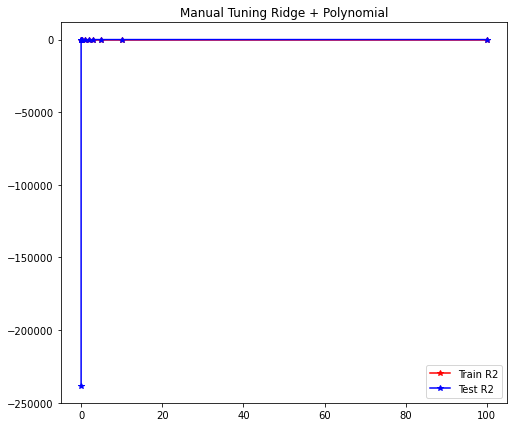

In [273]:
plt.figure(figsize=(8,7))
plt.plot(param_a,train_r,'r*-')
plt.plot(param_a,test_r,'b*-')
plt.legend(['Train R2','Test R2'])
plt.title('Manual Tuning Ridge + Polynomial')
plt.show()

In [274]:
np.max(test_r)

0.7773679559583417

In [275]:
param_a[np.argmax(test_r)]

1

In [276]:
model_R=Ridge(alpha=param_a[np.argmax(test_r)]) # Define Model dengan nilai Alpha sesuai nilai alpha maximum
model_R.fit(df_x_train_poly,y_train) # Training Model

Ridge(alpha=1)

In [309]:
## Ridge Training
r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train=Eva_Matrix(Model_R,df_x_train_poly,y_train)
## Ridge Testing
r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test=Eva_Matrix(Model_R,df_x_test_poly,y_test)

In [310]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Ridge(a=1)+Poly Training':[r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train],
    'Ridge(a=1)+Poly Testing':[r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test]
}
summary2_2=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary2_2.T

,R-Squared,MAE,MSE,RMSE
Ridge(a=1)+Poly Training,0.81,49.97,4814.20,69.38
Ridge(a=1)+Poly Testing,0.78,53.45,5378.35,73.34


### Lasso + polynomial feature

In [281]:
Model_L=Lasso()

In [282]:
Model_L.fit(df_x_train_poly,y_train)

Lasso()

In [283]:
## Lasso Training
r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train=Eva_Matrix(Model_L,df_x_train_poly,y_train)
## Lasso Testing
r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test=Eva_Matrix(Model_L,df_x_test_poly,y_test)

In [284]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Lasso+Poly Training':[r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train],
    'Lasso+Poly Testing':[r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test]
}
summary2_3=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary2_3.T

,R-Squared,MAE,MSE,RMSE
Lasso+Poly Training,0.73,59.87,6773.23,82.30
Lasso+Poly Testing,0.71,61.56,7064.90,84.05


In [285]:
## Manual Tuning Lasso

In [286]:
# param_a=np.arange(0,0.3,0.001)
param_a=[0,0.0001,0.001,0.01,0.1,1,2,3,5,10,100]

In [287]:
train_r = []
test_r = []

for i in param_a: # Melooping nilai dari param_a
    model_L=Lasso(alpha=i) # Define Model dengan nilai Alpha sesuai nilai i (looping)
    model_L.fit(df_x_train_poly,y_train) # Training Model
    y_pred_tr=model_L.predict(df_x_train_poly) # Model Predict data Training
    R2_train=r2_score(y_train,y_pred_tr) # Evaluation Matrix Data Training
    train_r.append(R2_train) # Memasukkan Hasil Eva Matrix ke list Training
    y_pred_ts=model_L.predict(df_x_test_poly) # Model Predict data testing
    R2_test=r2_score(y_test,y_pred_ts) #Evaluation Matrix Data Testing
    test_r.append(R2_test) # Memasukan Hasil Eva Matrix Data Testing ke Testing List


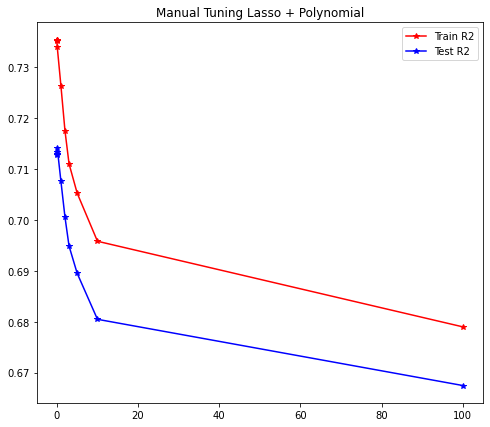

In [288]:
plt.figure(figsize=(8,7))
plt.plot(param_a,train_r,'r*-')
plt.plot(param_a,test_r,'b*-')
plt.legend(['Train R2','Test R2'])
plt.title('Manual Tuning Lasso + Polynomial')
plt.show()

In [289]:
np.max(test_r)

0.7140515793961346

In [290]:
param_a[np.argmax(test_r)]

0.1

In [291]:
model_L=Lasso(alpha=param_a[np.argmax(test_r)]) # Define Model dengan nilai Alpha sesuai nilai alpha maximum
model_L.fit(df_x_train_poly,y_train) # Training Model

Lasso(alpha=0.1)

In [292]:
## Lasso Training
r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train=Eva_Matrix(Model_L,df_x_train_poly,y_train)
## Ridge Testing
r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test=Eva_Matrix(Model_L,df_x_test_poly,y_test)

In [293]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Lasso(a=0.1)+Poly Training':[r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train],
    'Lasso(a=0.1)+Poly Testing':[r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test]
}
summary2_4=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary2_4.T

,R-Squared,MAE,MSE,RMSE
Lasso(a=0.1)+Poly Training,0.73,59.87,6773.23,82.30
Lasso(a=0.1)+Poly Testing,0.71,61.56,7064.90,84.05


### Elasticnet + polynomial feature

In [294]:
Model_E=ElasticNet()

In [295]:
Model_E.fit(df_x_train_poly,y_train)

ElasticNet()

In [296]:
## ElasticNet Training
r2_ElasticNet_Train,MAE_ElasticNet_Train,MSE_ElasticNet_Train,RMSE_ElasticNet_Train=Eva_Matrix(Model_E,df_x_train_poly,y_train)
## ElasticNet Testing
r2_ElasticNet_Test,MAE_ElasticNet_Test,MSE_ElasticNet_Test,RMSE_ElasticNet_Test=Eva_Matrix(Model_E,df_x_test_poly,y_test)

In [297]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'ENet+Poly Training':[r2_ElasticNet_Train,MAE_ElasticNet_Train,MSE_ElasticNet_Train,RMSE_ElasticNet_Train],
    'ENet+Poly Testing':[r2_ElasticNet_Test,MAE_ElasticNet_Test,MSE_ElasticNet_Test,RMSE_ElasticNet_Test]
}
summary2_5=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary2_5.T

,R-Squared,MAE,MSE,RMSE
ENet+Poly Training,0.71,61.49,7055.69,84.00
ENet+Poly Testing,0.70,63.17,7329.83,85.61


In [298]:
## Manual Tuning ENet

In [299]:
# param_a=np.arange(0,0.3,0.001)
param_a=[0,0.0001,0.001,0.01,0.1,1,2,3,5,10,100]

In [300]:
train_r = []
test_r = []

for i in param_a: # Melooping nilai dari param_a
    model_E=ElasticNet(alpha=i) # Define Model dengan nilai Alpha sesuai nilai i (looping)
    model_E.fit(df_x_train_poly,y_train) # Training Model
    y_pred_tr=model_E.predict(df_x_train_poly) # Model Predict data Training
    R2_train=r2_score(y_train,y_pred_tr) # Evaluation Matrix Data Training
    train_r.append(R2_train) # Memasukkan Hasil Eva Matrix ke list Training
    y_pred_ts=model_E.predict(df_x_test_poly) # Model Predict data testing
    R2_test=r2_score(y_test,y_pred_ts) #Evaluation Matrix Data Testing
    test_r.append(R2_test) # Memasukan Hasil Eva Matrix Data Testing ke Testing List


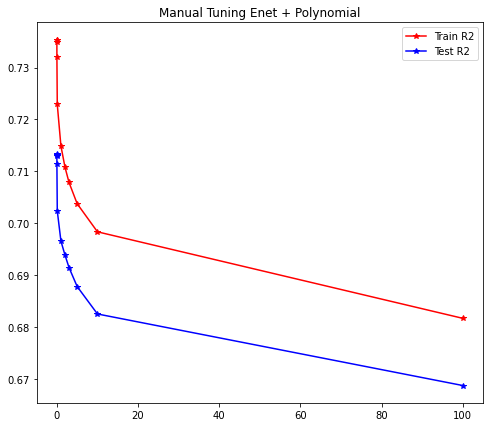

In [301]:
plt.figure(figsize=(8,7))
plt.plot(param_a,train_r,'r*-')
plt.plot(param_a,test_r,'b*-')
plt.legend(['Train R2','Test R2'])
plt.title('Manual Tuning Enet + Polynomial')
plt.show()

In [302]:
np.max(test_r)

0.7132595851526925

In [303]:
param_a[np.argmax(test_r)]

0

In [304]:
model_L=ElasticNet(alpha=param_a[np.argmax(test_r)]) # Define Model dengan nilai Alpha sesuai nilai alpha maximum
model_L.fit(df_x_train_poly,y_train) # Training Model

ElasticNet(alpha=0)

In [305]:
## ElasticNet Training
r2_ElasticNet_Train,MAE_ElasticNet_Train,MSE_ElasticNet_Train,RMSE_ElasticNet_Train=Eva_Matrix(Model_E,df_x_train_poly,y_train)
## ElasticNet Testing
r2_ElasticNet_Test,MAE_ElasticNet_Test,MSE_ElasticNet_Test,RMSE_ElasticNet_Test=Eva_Matrix(Model_E,df_x_test_poly,y_test)

In [306]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'ENet(alpha=0.0001)+Poly Training':[r2_ElasticNet_Train,MAE_ElasticNet_Train,MSE_ElasticNet_Train,RMSE_ElasticNet_Train],
    'ENet(alpha=0.0001)+Poly Testing':[r2_ElasticNet_Test,MAE_ElasticNet_Test,MSE_ElasticNet_Test,RMSE_ElasticNet_Test]
}
summary2_6=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(2)
summary2_6.T

,R-Squared,MAE,MSE,RMSE
ENet(alpha=0.0001)+Poly Training,0.71,61.49,7055.69,84.00
ENet(alpha=0.0001)+Poly Testing,0.70,63.17,7329.83,85.61


### Evaluation Matrix Summary

Without Binning

In [312]:
pd.concat([summary1.T,summary1_1.T])

,R-Squared,MAE,MSE,RMSE
Linear Regression Training,0.36,95.41,15713.53,125.35
Linear Regression Testing,0.37,94.46,15507.58,124.53
LinReg after Polynomial Features Training,0.67,65.60,8158.41,90.32
LinReg after Polynomial Features Testing,0.63,69.20,9017.06,94.96
Ridge Training,0.40,92.95,14858.32,121.89
Ridge Testing,0.39,93.29,14961.48,122.32
Lasso Training,0.40,93.03,14868.56,121.94
Lasso Testing,0.39,93.24,14940.30,122.23
Elasticnet Training,0.39,93.58,15159.33,123.12
Elasticnet Testing,0.39,93.58,15159.33,123.12


With Binning

In [311]:
pd.concat([summary2.T,summary2_1.T,summary2_2.T,summary2_3.T,summary2_4.T,summary2_5.T,summary2_6.T])

,R-Squared,MAE,MSE,RMSE
Linear Regression Training,0.42,91.30,14351.03,119.80
Linear Regression Testing,0.42,90.21,14115.56,118.81
LinReg after Polynomial Features Training,0.81,48.89,4605.90,67.87
LinReg after Polynomial Features Testing,0.62,53.83,9293.94,96.41
Ridge Training,0.46,88.37,13484.98,116.12
Ridge Testing,0.46,86.22,13132.77,114.60
Lasso Training,0.45,88.75,13560.86,116.45
Lasso Testing,0.45,86.30,13191.76,114.86
Elasticnet Training,0.38,92.03,14891.90,122.03
Elasticnet Testing,0.38,92.03,14891.90,122.03
